In [1]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

# try:
#   tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#   print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
# except ValueError:
#   raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

UsageError: Line magic function `%tensorflow_version` not found.


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
!pip install tensorflow_datasets
!pip install -U 'tensorflow-text==2.8.*'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 6.7 MB/s eta 0:00:0000:0100:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.9/497.9 MB 1.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 24.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 56.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 71.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 38.3 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.3/462.3 kB 34.0 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: keras
    Found existing installation: keras 2.6.0
    Uninstalling keras-2.6.0:
      Successfully uninstalled keras-2.6.0
  Attempting uninstall: tensorboard
    Fou

In [4]:
import collections
import os
import pathlib
import re
import string
import sys
import tempfile
import time

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_text as text
import pandas as pd
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
import keras
import logging



In [5]:

logging.getLogger('tensorflow').setLevel(logging.ERROR)  

In [7]:
dataset = pd.read_csv("/kaggle/input/c-code-from-c-code-corpus/prediction_test.csv")
dataset

,file,function_name,arg1,arg2,arg_type,param1,param2,labels,full_text,prediction
0,cleaned/uclibc/test/string/tester.c,check,1,*,int,thing,number,1,check 1 * int thing number,1
1,cleaned/freebsd/usr.sbin/mountd/mountd.c,strcmp,index,cpopt,const char *,__s1,__s2,1,strcmp index cpopt const char * __s1 __s2,1
2,cleaned/freebsd/lib/msun/src/catrig.c,atan2,sqrt_A2mx2,new_x,double,__y,__x,0,atan2 sqrt_A2mx2 new_x double __y __x,1
3,cleaned/ssvpn-macos/tunnelblick/third_party/op...,strcmp,%d,term,const char *,[UNK],[UNK],1,strcmp %d term const char * [UNK] [UNK],1
4,cleaned/torque/src/scheduler.cc/samples/cray_t...,strcmp,ENFORCE_ALLOCATION,cfg_option,const char *,__s1,__s2,1,strcmp ENFORCE_ALLOCATION cfg_option const cha...,1
...,...,...,...,...,...,...,...,...,...,...
26460,cleaned/apophnia/mongoose/main.c,strcmp,argv,-h,const char *,__s1,__s2,0,strcmp argv -h const char * __s1 __s2,0
26461,cleaned/v4/src/borg/borg9.c,streq,The door appears to be stuck.,msg,char *,[UNK],[UNK],1,streq The door appears to be stuck. msg char *...,1
26462,cleaned/xbmc/lib/timidity/timidity/timidity.c,strcmp,exclude,w,const char *,__s1,__s2,1,strcmp exclude w const char * __s1 __s2,1
26463,cleaned/sane-backends/backend/hp3900_sane.c,hp3800_calibtransparent,defvalue,option,int,option,defvalue,1,hp3800_calibtransparent defvalue option int op...,1


In [13]:
dataset.drop(['file','function_name','arg1','arg2','arg_type','param1','param2','prediction'],axis=1,inplace=True)

In [14]:
dataset

,labels,full_text
0,1,check 1 * int thing number
1,1,strcmp index cpopt const char * __s1 __s2
2,0,atan2 sqrt_A2mx2 new_x double __y __x
3,1,strcmp %d term const char * [UNK] [UNK]
4,1,strcmp ENFORCE_ALLOCATION cfg_option const cha...
...,...,...
26460,0,strcmp argv -h const char * __s1 __s2
26461,1,streq The door appears to be stuck. msg char *...
26462,1,strcmp exclude w const char * __s1 __s2
26463,1,hp3800_calibtransparent defvalue option int op...


In [15]:
train_examples = dataset[:6000]
val_examples = dataset[6000:8000]
test_examples = dataset[8000:10000]

In [16]:
train_data = tf.data.Dataset.from_tensor_slices(train_examples)
val_data = tf.data.Dataset.from_tensor_slices(val_examples)
tf.data.experimental.cardinality(val_data)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

In [ ]:
print(tf.data.experimental.cardinality(val_data))
print(tf.data.experimental.cardinality(train_data))

tf.Tensor(2000, shape=(), dtype=int64)

tf.Tensor(10000, shape=(), dtype=int64)


In [ ]:
val_prob = []
for i in range(0,len(val_examples)):
  val_prob.append(str(val_examples.iloc[i,0]))

# inputs = val_examples['problem']
print(val_prob[0])
print(type(val_prob))

val_sol = []
for i in range(0,len(val_examples)):
  val_sol.append(str(val_examples.iloc[i,1]))

# inputs = val_examples['solution']
print(val_sol[0])
print(type(val_sol))

val_p = tf.convert_to_tensor(val_prob)
val_s = tf.convert_to_tensor(val_sol)

val_data = tf.data.Dataset.from_tensor_slices((val_p,val_s))

tf.data.experimental.cardinality(val_data)

declare ints n_ b and p    read variables n_ b and p from the input    create ints bowl = 0 and towl = n * p    while n > 1    new integer k = pow(2_ (log(n) / log(2)))    increase bowl by k / 2 * (2 * b + 1)    change n to n - k / 2        print bowl_ ' ' and towl to the standard output            

<class 'list'>

int n_ b_ p;    cin >> n >> b >> p;    int bowl = 0_ towl = n * p;    while (n > 1) {    int k = pow(2_ (int)(log(n) / log(2)));    bowl += k / 2 * (2 * b + 1);    n -= k / 2;    }    cout << bowl << ' ' << towl << endl;    return 0;    }    

<class 'list'>


<tf.Tensor: shape=(), dtype=int64, numpy=2000>

In [ ]:
train_prob = []
for i in range(0,len(train_examples)):
  train_prob.append(str(train_examples.iloc[i,0]))

# inputs = train_examples['problem']
print(train_prob[0])
print(type(train_prob))

train_sol = []
for i in range(0,len(train_examples)):
  train_sol.append(str(train_examples.iloc[i,1]))

# inputs = train_examples['solution']
print(train_sol[0])
print(type(train_sol))

train_p = tf.convert_to_tensor(train_prob)
train_s = tf.convert_to_tensor(train_sol)

train_data = tf.data.Dataset.from_tensor_slices((train_p,train_s))

tf.data.experimental.cardinality(train_data)

if b=1 return a_ else call function gcd(b_ a%b)            n _ nn_ ans = integers with ans =0    Read n    for i=2 to n-1 execute    set nn to n    while nn is not equal to 0_ set ans to ans + nn%i_ and also set nn= nn/i        set o to gcd(ans_ n-2)    print out ans/o "/" (n-2)/o            function gcd with integer arguments a and b    return !b ? a : gcd(b_ a % b)            integers n_ nn and ans = 0    read n    for i = 2 to n - 1 inclusive    set nn to n    while nn increment ans by (nn % i) and set nn to nn / i;        integer o = gcd of ans and n - 2    print ans / o_ "/"_ (n - 2) / o and "\n"            

<class 'list'>

return !b ? a : gcd(b_ a % b);    }    int main() {    int n_ nn_ ans = 0;    cin >> n;    for (int i = 2; i <= n - 1; ++i) {    nn = n;    while (nn) ans += nn % i_ nn /= i;    }    int o = gcd(ans_ n - 2);    cout << ans / o << "/" << (n - 2) / o << "\n";    return 0;    }    int gcd(int a_ int b) {    return !b ? a : gcd(b_ a % b);    }    int main() {    i

<tf.Tensor: shape=(), dtype=int64, numpy=10000>

In [ ]:
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab

In [ ]:
bert_tokenizer_params=dict(lower_case=True)
reserved_tokens=["[PAD]", "[UNK]", "[START]", "[END]"]

bert_vocab_args = dict(
    # The target vocabulary size
    vocab_size = 10000,
    # Reserved tokens that must be included in the vocabulary
    reserved_tokens=reserved_tokens,
    # Arguments for `text.BertTokenizer`
    bert_tokenizer_params=bert_tokenizer_params,
    # Arguments for `wordpiece_vocab.wordpiece_tokenizer_learner_lib.learn`
    learn_params={},
)

In [ ]:
train_pb = tf.data.Dataset.from_tensor_slices(train_p)
train_sl = tf.data.Dataset.from_tensor_slices(train_s)

In [ ]:
%%time
prob_vocab = bert_vocab.bert_vocab_from_dataset(
    train_pb.batch(2000).prefetch(20),
    **bert_vocab_args
)
sol_vocab = bert_vocab.bert_vocab_from_dataset(
    train_sl.batch(2000).prefetch(20),
    **bert_vocab_args
)

CPU times: user 35.9 s, sys: 158 ms, total: 36.1 s

Wall time: 46.2 s


In [ ]:
print(prob_vocab[:10])
print(prob_vocab[100:110])
print(prob_vocab[1000:1010])
print(prob_vocab[-10:])
print()
print(sol_vocab[:10])
print(sol_vocab[100:110])
print(sol_vocab[1000:1010])
print(sol_vocab[-10:])

['[PAD]', '[UNK]', '[START]', '[END]', '!', '"', '#', '%', '&', "'"]

['sum', 'inclusive', 'value', 'greater', 'while', 'be', 'or', 'loop', 'less', 'string']

['di', 'factor', 'g1', 'gl', 'imin', 'ke', 'may', 'multiplied', 'par', 'plen']

['##[', '##\\', '##]', '##^', '##_', '##`', '##{', '##|', '##}', '##~']



['[PAD]', '[UNK]', '[START]', '[END]', '!', '"', '#', '%', '&', "'"]

['temp', 'true', 'abs', 'bool', 's2', 'false', 'dp', 'push', 'length', 'sort']

['endy', 'go', 'home', 'incorrect', 'interval', 'ios', 'isp', 'lena', 'lj', 'lsum']

['##[', '##\\', '##]', '##^', '##_', '##`', '##{', '##|', '##}', '##~']


In [ ]:
def write_vocab_file(filepath, vocab):
  with open(filepath, 'w') as f:
    for token in vocab:
      print(token, file=f)

In [ ]:
write_vocab_file('prob_vocab.txt', prob_vocab)
write_vocab_file('sol_vocab.txt', sol_vocab)

In [ ]:
!ls *.txt

prob_vocab.txt	sol_vocab.txt


In [ ]:
prob_tokenizer = text.BertTokenizer('/content/prob_vocab.txt', **bert_tokenizer_params)
sol_tokenizer = text.BertTokenizer('/content/sol_vocab.txt', **bert_tokenizer_params)


In [ ]:
for pb_examples in train_pb.batch(2).take(1):
  for ex in pb_examples:
    print(ex.numpy())
print()
for sol_examples in train_sl.batch(2).take(1):
  for ex in sol_examples:
    print(ex.numpy())

b'if b=1 return a_ else call function gcd(b_ a%b)            n _ nn_ ans = integers with ans =0    Read n    for i=2 to n-1 execute    set nn to n    while nn is not equal to 0_ set ans to ans + nn%i_ and also set nn= nn/i        set o to gcd(ans_ n-2)    print out ans/o "/" (n-2)/o            function gcd with integer arguments a and b    return !b ? a : gcd(b_ a % b)            integers n_ nn and ans = 0    read n    for i = 2 to n - 1 inclusive    set nn to n    while nn increment ans by (nn % i) and set nn to nn / i;        integer o = gcd of ans and n - 2    print ans / o_ "/"_ (n - 2) / o and "\\n"            '

b'let a and b be strings    n = integer    st = set of strings    read n    for integer i = 0 to n exclusive    read a and b    insert a + " " + b into st        print size of st and a new line            '



b'return !b ? a : gcd(b_ a % b);    }    int main() {    int n_ nn_ ans = 0;    cin >> n;    for (int i = 2; i <= n - 1; ++i) {    nn = n;    while (nn) ans += nn %

In [ ]:
# prob_lookup = tf.lookup.StaticVocabularyTable(
#     num_oov_buckets=1,
#     initializer=tf.lookup.TextFileInitializer(
#         filename='/content/prob_vocab.txt',
#         key_dtype=tf.string,
#         key_index = tf.lookup.TextFileIndex.WHOLE_LINE,
#         value_dtype = tf.int64,
#         value_index=tf.lookup.TextFileIndex.LINE_NUMBER)) 
# prob_tokenizer = text.BertTokenizer(prob_lookup)

In [ ]:
# sol_lookup = tf.lookup.StaticVocabularyTable(
#     num_oov_buckets=1,
#     initializer=tf.lookup.TextFileInitializer(
#         filename='sol_vocab.txt',
#         key_dtype=tf.string,
#         key_index = tf.lookup.TextFileIndex.WHOLE_LINE,
#         value_dtype = tf.int64,
#         value_index=tf.lookup.TextFileIndex.LINE_NUMBER)) 
# sol_tokenizer = text.BertTokenizer(sol_lookup)

In [ ]:
# Tokenize the examples -> (batch, word, word-piece)
token_batch_prob = prob_tokenizer.tokenize(pb_examples)
# Merge the word and word-piece axes -> (batch, tokens)
token_batch_prob = token_batch_prob.merge_dims(-2,-1)

for ex in token_batch_prob.to_list():
  print(ex)

[71, 41, 30, 18, 111, 40, 38, 82, 184, 124, 176, 10, 41, 38, 40, 7, 41, 11, 53, 38, 483, 38, 85, 30, 92, 81, 85, 30, 17, 75, 53, 76, 48, 30, 19, 70, 53, 14, 18, 832, 78, 483, 70, 53, 104, 483, 72, 113, 88, 70, 17, 38, 78, 85, 70, 85, 13, 483, 7, 48, 38, 74, 40, 285, 168, 319, 78, 483, 30, 483, 16, 48, 78, 54, 70, 176, 10, 85, 38, 53, 14, 19, 11, 73, 335, 85, 16, 54, 5, 16, 5, 10, 53, 14, 19, 11, 16, 54, 124, 176, 81, 79, 156, 40, 74, 41, 111, 4, 41, 32, 40, 27, 176, 10, 41, 38, 40, 7, 41, 11, 92, 53, 38, 483, 74, 85, 30, 17, 75, 53, 76, 48, 30, 19, 70, 53, 14, 18, 101, 78, 483, 70, 53, 104, 483, 87, 85, 90, 10, 483, 7, 48, 11, 74, 78, 483, 70, 483, 16, 48, 28, 79, 54, 30, 176, 77, 85, 74, 53, 14, 19, 73, 85, 16, 54, 38, 5, 16, 5, 38, 10, 53, 14, 19, 11, 16, 54, 74, 5, 35, 53, 5]

[97, 40, 74, 41, 105, 177, 53, 30, 79, 188, 30, 78, 77, 177, 75, 53, 76, 79, 48, 30, 17, 70, 53, 84, 75, 40, 74, 41, 233, 40, 13, 5, 5, 13, 41, 153, 188, 73, 95, 77, 188, 74, 40, 98, 110]


In [ ]:


# Tokenize the examples -> (batch, word, word-piece)
token_batch_sol = sol_tokenizer.tokenize(sol_examples)
# Merge the word and word-piece axes -> (batch, tokens)
token_batch_sol = token_batch_sol.merge_dims(-2,-1)

for ex in token_batch_sol.to_list():
  print(ex)


[77, 4, 41, 32, 40, 27, 120, 10, 41, 38, 40, 7, 41, 11, 28, 68, 70, 80, 10, 11, 66, 70, 53, 38, 382, 38, 79, 30, 17, 28, 73, 31, 31, 53, 28, 74, 10, 70, 48, 30, 19, 28, 48, 29, 30, 53, 14, 18, 28, 13, 13, 48, 11, 66, 382, 30, 53, 28, 81, 10, 382, 11, 79, 13, 30, 382, 7, 48, 38, 382, 16, 30, 48, 28, 68, 70, 54, 30, 120, 10, 79, 38, 53, 14, 19, 11, 28, 72, 29, 29, 79, 16, 54, 29, 29, 5, 16, 5, 29, 29, 10, 53, 14, 19, 11, 16, 54, 29, 29, 5, 35, 53, 5, 28, 77, 17, 28, 68, 70, 120, 10, 70, 40, 38, 70, 41, 11, 66, 77, 4, 41, 32, 40, 27, 120, 10, 41, 38, 40, 7, 41, 11, 28, 68, 70, 80, 10, 11, 66, 70, 53, 38, 382, 38, 79, 30, 17, 28, 73, 31, 31, 53, 28, 74, 10, 70, 48, 30, 19, 28, 48, 29, 30, 53, 14, 18, 28, 13, 13, 48, 11, 66, 382, 30, 53, 28, 81, 10, 382, 11, 79, 13, 30, 382, 7, 48, 38, 382, 16, 30, 48, 28, 68, 70, 54, 30, 120, 10, 79, 38, 53, 14, 19, 11, 28, 72, 29, 29, 79, 16, 54, 29, 29, 5, 16, 5, 29, 29, 10, 53, 14, 19, 11, 16, 54, 29, 29, 5, 35, 53, 5, 28, 77, 17, 28, 68]

[83, 40, 38, 

In [ ]:
# Lookup each token id in the vocabulary.
txt_tokens_prob = tf.gather(prob_vocab, token_batch_prob)
# Join with spaces.
tf.strings.reduce_join(txt_tokens_prob, separator=' ', axis=-1)



<tf.Tensor: shape=(2,), dtype=string, numpy=
array([b'if b = 1 return a _ else call function gcd ( b _ a % b ) n _ nn _ ans = integers with ans = 0 read n for i = 2 to n - 1 execute set nn to n while nn is not equal to 0 _ set ans to ans + nn % i _ and a ##l ##s ##o set nn = nn / i set o to gcd ( ans _ n - 2 ) print out ans / o " / " ( n - 2 ) / o function gcd with integer arguments a and b return ! b ? a : gcd ( b _ a % b ) integers n _ nn and ans = 0 read n for i = 2 to n - 1 inclusive set nn to n while nn increment ans by ( nn % i ) and set nn to nn / i ; integer o = gcd of ans and n - 2 print ans / o _ " / " _ ( n - 2 ) / o and " \\ n "',
       b'let a and b be strings n = integer st = set of strings read n for integer i = 0 to n exclusive read a and b insert a + " " + b into st print size of st and a new line'],
      dtype=object)>

In [ ]:
# Lookup each token id in the vocabulary.
txt_tokens_sol = tf.gather(sol_vocab, token_batch_sol)
# Join with spaces.
tf.strings.reduce_join(txt_tokens_sol, separator=' ', axis=-1)

<tf.Tensor: shape=(2,), dtype=string, numpy=
array([b'return ! b ? a : gcd ( b _ a % b ) ; } int main ( ) { int n _ nn _ ans = 0 ; cin > > n ; for ( int i = 2 ; i < = n - 1 ; + + i ) { nn = n ; while ( nn ) ans + = nn % i _ nn / = i ; } int o = gcd ( ans _ n - 2 ) ; cout < < ans / o < < " / " < < ( n - 2 ) / o < < " \\ n " ; return 0 ; } int gcd ( int a _ int b ) { return ! b ? a : gcd ( b _ a % b ) ; } int main ( ) { int n _ nn _ ans = 0 ; cin > > n ; for ( int i = 2 ; i < = n - 1 ; + + i ) { nn = n ; while ( nn ) ans + = nn % i _ nn / = i ; } int o = gcd ( ans _ n - 2 ) ; cout < < ans / o < < " / " < < ( n - 2 ) / o < < " \\ n " ; return 0 ; }',
       b'string a _ b ; int n ; set < string > st ; cin > > n ; for ( int i = 0 ; i < n ; i + + ) { cin > > a > > b ; st . insert ( a + " " + b ) ; } cout < < st . size ( ) < < endl ; return 0 ; }'],
      dtype=object)>

In [ ]:
prob_words = prob_tokenizer.detokenize(token_batch_prob)
tf.strings.reduce_join(prob_words, separator=' ', axis=-1)

sol_words = sol_tokenizer.detokenize(token_batch_sol)
tf.strings.reduce_join(sol_words, separator=' ', axis=-1)

<tf.Tensor: shape=(2,), dtype=string, numpy=
array([b'return ! b ? a : gcd ( b _ a % b ) ; } int main ( ) { int n _ nn _ ans = 0 ; cin > > n ; for ( int i = 2 ; i < = n - 1 ; + + i ) { nn = n ; while ( nn ) ans + = nn % i _ nn / = i ; } int o = gcd ( ans _ n - 2 ) ; cout < < ans / o < < " / " < < ( n - 2 ) / o < < " \\ n " ; return 0 ; } int gcd ( int a _ int b ) { return ! b ? a : gcd ( b _ a % b ) ; } int main ( ) { int n _ nn _ ans = 0 ; cin > > n ; for ( int i = 2 ; i < = n - 1 ; + + i ) { nn = n ; while ( nn ) ans + = nn % i _ nn / = i ; } int o = gcd ( ans _ n - 2 ) ; cout < < ans / o < < " / " < < ( n - 2 ) / o < < " \\ n " ; return 0 ; }',
       b'string a _ b ; int n ; set < string > st ; cin > > n ; for ( int i = 0 ; i < n ; i + + ) { cin > > a > > b ; st . insert ( a + " " + b ) ; } cout < < st . size ( ) < < endl ; return 0 ; }'],
      dtype=object)>

In [ ]:
START = tf.argmax(tf.constant(reserved_tokens) == "[START]")
END = tf.argmax(tf.constant(reserved_tokens) == "[END]")

def add_start_end(ragged):
  count = ragged.bounding_shape()[0]
  starts = tf.fill([count,1], START)
  ends = tf.fill([count,1], END)
  return tf.concat([starts, ragged, ends], axis=1)

In [ ]:
prob_words = prob_tokenizer.detokenize(add_start_end(token_batch_prob))
tf.strings.reduce_join(prob_words, separator=' ', axis=-1)

<tf.Tensor: shape=(2,), dtype=string, numpy=
array([b'[START] if b = 1 return a _ else call function gcd ( b _ a % b ) n _ nn _ ans = integers with ans = 0 read n for i = 2 to n - 1 execute set nn to n while nn is not equal to 0 _ set ans to ans + nn % i _ and also set nn = nn / i set o to gcd ( ans _ n - 2 ) print out ans / o " / " ( n - 2 ) / o function gcd with integer arguments a and b return ! b ? a : gcd ( b _ a % b ) integers n _ nn and ans = 0 read n for i = 2 to n - 1 inclusive set nn to n while nn increment ans by ( nn % i ) and set nn to nn / i ; integer o = gcd of ans and n - 2 print ans / o _ " / " _ ( n - 2 ) / o and " \\ n " [END]',
       b'[START] let a and b be strings n = integer st = set of strings read n for integer i = 0 to n exclusive read a and b insert a + " " + b into st print size of st and a new line [END]'],
      dtype=object)>

In [ ]:
sol_words = sol_tokenizer.detokenize(add_start_end(token_batch_sol))
tf.strings.reduce_join(sol_words, separator=' ', axis=-1)

<tf.Tensor: shape=(2,), dtype=string, numpy=
array([b'[START] return ! b ? a : gcd ( b _ a % b ) ; } int main ( ) { int n _ nn _ ans = 0 ; cin > > n ; for ( int i = 2 ; i < = n - 1 ; + + i ) { nn = n ; while ( nn ) ans + = nn % i _ nn / = i ; } int o = gcd ( ans _ n - 2 ) ; cout < < ans / o < < " / " < < ( n - 2 ) / o < < " \\ n " ; return 0 ; } int gcd ( int a _ int b ) { return ! b ? a : gcd ( b _ a % b ) ; } int main ( ) { int n _ nn _ ans = 0 ; cin > > n ; for ( int i = 2 ; i < = n - 1 ; + + i ) { nn = n ; while ( nn ) ans + = nn % i _ nn / = i ; } int o = gcd ( ans _ n - 2 ) ; cout < < ans / o < < " / " < < ( n - 2 ) / o < < " \\ n " ; return 0 ; } [END]',
       b'[START] string a _ b ; int n ; set < string > st ; cin > > n ; for ( int i = 0 ; i < n ; i + + ) { cin > > a > > b ; st . insert ( a + " " + b ) ; } cout < < st . size ( ) < < endl ; return 0 ; } [END]'],
      dtype=object)>

In [ ]:
def cleanup_text(reserved_tokens, token_txt):
  # Drop the reserved tokens, except for "[UNK]".
  bad_tokens = [re.escape(tok) for tok in reserved_tokens if tok != "[UNK]"]
  bad_token_re = "|".join(bad_tokens)
    
  bad_cells = tf.strings.regex_full_match(token_txt, bad_token_re)
  result = tf.ragged.boolean_mask(token_txt, ~bad_cells)

  # Join them into strings.
  result = tf.strings.reduce_join(result, separator=' ', axis=-1)

  return result

In [ ]:
token_batch = sol_tokenizer.tokenize(sol_examples).merge_dims(-2,-1)
words =sol_tokenizer.detokenize(token_batch)
words

<tf.RaggedTensor [[b'return', b'!', b'b', b'?', b'a', b':', b'gcd', b'(', b'b', b'_', b'a',
  b'%', b'b', b')', b';', b'}', b'int', b'main', b'(', b')', b'{', b'int',
  b'n', b'_', b'nn', b'_', b'ans', b'=', b'0', b';', b'cin', b'>', b'>',
  b'n', b';', b'for', b'(', b'int', b'i', b'=', b'2', b';', b'i', b'<',
  b'=', b'n', b'-', b'1', b';', b'+', b'+', b'i', b')', b'{', b'nn', b'=',
  b'n', b';', b'while', b'(', b'nn', b')', b'ans', b'+', b'=', b'nn', b'%',
  b'i', b'_', b'nn', b'/', b'=', b'i', b';', b'}', b'int', b'o', b'=',
  b'gcd', b'(', b'ans', b'_', b'n', b'-', b'2', b')', b';', b'cout', b'<',
  b'<', b'ans', b'/', b'o', b'<', b'<', b'"', b'/', b'"', b'<', b'<', b'(',
  b'n', b'-', b'2', b')', b'/', b'o', b'<', b'<', b'"', b'\\', b'n', b'"',
  b';', b'return', b'0', b';', b'}', b'int', b'gcd', b'(', b'int', b'a',
  b'_', b'int', b'b', b')', b'{', b'return', b'!', b'b', b'?', b'a', b':',
  b'gcd', b'(', b'b', b'_', b'a', b'%', b'b', b')', b';', b'}', b'int',
  b'main', b'(', b')

In [ ]:
cleanup_text(reserved_tokens, words).numpy()

array([b'return ! b ? a : gcd ( b _ a % b ) ; } int main ( ) { int n _ nn _ ans = 0 ; cin > > n ; for ( int i = 2 ; i < = n - 1 ; + + i ) { nn = n ; while ( nn ) ans + = nn % i _ nn / = i ; } int o = gcd ( ans _ n - 2 ) ; cout < < ans / o < < " / " < < ( n - 2 ) / o < < " \\ n " ; return 0 ; } int gcd ( int a _ int b ) { return ! b ? a : gcd ( b _ a % b ) ; } int main ( ) { int n _ nn _ ans = 0 ; cin > > n ; for ( int i = 2 ; i < = n - 1 ; + + i ) { nn = n ; while ( nn ) ans + = nn % i _ nn / = i ; } int o = gcd ( ans _ n - 2 ) ; cout < < ans / o < < " / " < < ( n - 2 ) / o < < " \\ n " ; return 0 ; }',
       b'string a _ b ; int n ; set < string > st ; cin > > n ; for ( int i = 0 ; i < n ; i + + ) { cin > > a > > b ; st . insert ( a + " " + b ) ; } cout < < st . size ( ) < < endl ; return 0 ; }'],
      dtype=object)

In [ ]:
class CustomTokenizer(tf.Module):
  def __init__(self, reserved_tokens, vocab_path):
    self.tokenizer = text.BertTokenizer(vocab_path, lower_case=True)
    self._reserved_tokens = reserved_tokens
    self._vocab_path = tf.saved_model.Asset(vocab_path)

    vocab = pathlib.Path(vocab_path).read_text().splitlines()
    self.vocab = tf.Variable(vocab)

    ## Create the signatures for export:   

    # Include a tokenize signature for a batch of strings. 
    self.tokenize.get_concrete_function(
        tf.TensorSpec(shape=[None], dtype=tf.string))

    # Include `detokenize` and `lookup` signatures for:
    #   * `Tensors` with shapes [tokens] and [batch, tokens]
    #   * `RaggedTensors` with shape [batch, tokens]
    self.detokenize.get_concrete_function(
        tf.TensorSpec(shape=[None, None], dtype=tf.int64))
    self.detokenize.get_concrete_function(
          tf.RaggedTensorSpec(shape=[None, None], dtype=tf.int64))

    self.lookup.get_concrete_function(
        tf.TensorSpec(shape=[None, None], dtype=tf.int64))
    self.lookup.get_concrete_function(
          tf.RaggedTensorSpec(shape=[None, None], dtype=tf.int64))

    # These `get_*` methods take no arguments
    self.get_vocab_size.get_concrete_function()
    self.get_vocab_path.get_concrete_function()
    self.get_reserved_tokens.get_concrete_function()

  @tf.function
  def tokenize(self, strings):
    enc = self.tokenizer.tokenize(strings)
    # Merge the `word` and `word-piece` axes.
    enc = enc.merge_dims(-2,-1)
    enc = add_start_end(enc)
    return enc

  @tf.function
  def detokenize(self, tokenized):
    words = self.tokenizer.detokenize(tokenized)
    return cleanup_text(self._reserved_tokens, words)

  @tf.function
  def lookup(self, token_ids):
    return tf.gather(self.vocab, token_ids)

  @tf.function
  def get_vocab_size(self):
    return tf.shape(self.vocab)[0]

  @tf.function
  def get_vocab_path(self):
    return self._vocab_path

  @tf.function
  def get_reserved_tokens(self):
    return tf.constant(self._reserved_tokens)

In [ ]:
tokenizers = tf.Module()
tokenizers.prob = CustomTokenizer(reserved_tokens, '/content/prob_vocab.txt')
tokenizers.sol = CustomTokenizer(reserved_tokens, '/content/sol_vocab.txt')

In [ ]:
model_name = 'spoc_pseudocode_to_code_converter'
tf.saved_model.save(tokenizers, model_name)

In [ ]:
# !unzip 'spoc_pseudocode_to_code_converter.zip'

In [ ]:
# model_name = 'spoc_pseudocode_to_code_converter'


In [ ]:
tokenizers = tf.saved_model.load(model_name)
print(tokenizers.prob.get_vocab_size().numpy())
print(tokenizers.sol.get_vocab_size().numpy())

1932

1667


In [ ]:
# investigate the distribution of tokens per example in the dataset:

lengths = []

for p, s in train_data.batch(1024):
  
  prob_tokens = tokenizers.sol.tokenize(p)
  lengths.append(prob_tokens.row_lengths())

  sol_tokens = tokenizers.sol.tokenize(s)
  lengths.append(sol_tokens.row_lengths())
  # print('.', end='', flush=True)



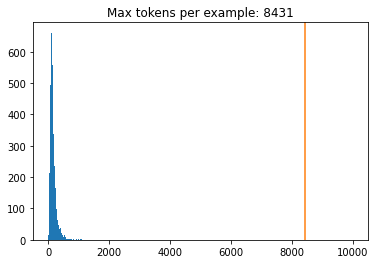

In [ ]:
all_lengths = np.concatenate(lengths)

plt.hist(all_lengths, np.linspace(0, 10000, 2000))
plt.ylim(plt.ylim())
max_length = max(all_lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Max tokens per example: {max_length}');

In [ ]:
# from above figure
MAX_TOKENS = 500

In [ ]:
#  a function to drop the examples longer than MAX_TOKENS:
def filter_max_tokens(prob, sol):
  num_tokens = tf.maximum(tf.shape(prob)[1],tf.shape(sol)[1])
  return num_tokens < MAX_TOKENS

In [ ]:
# a function that tokenizes the batches of raw text
def tokenize_pairs(prob, sol):
    prob = tokenizers.prob.tokenize(prob)
    # Convert from ragged to dense, padding with zeros.
    prob = prob.to_tensor()

    sol = tokenizers.sol.tokenize(sol)
    # Convert from ragged to dense, padding with zeros.
    sol = sol.to_tensor()
    return prob, sol

In [ ]:
# for p , s in val_data:
#   print(p)
#   print(s)

In [ ]:
# for p , s in train_data:
#   print(p)
#   print(s)

In [ ]:
# input pipeline that processes, shuffles and batches the data

BUFFER_SIZE = 20000
BATCH_SIZE = 64

def make_batches(ds):
  return (
      ds
      .cache()
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE)
      .filter(filter_max_tokens)
      .prefetch(tf.data.AUTOTUNE))



In [ ]:
train_batches = make_batches(train_data)

In [ ]:
val_batches = make_batches(val_data)

In [ ]:
#positional encoding
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [ ]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 2048, 512)


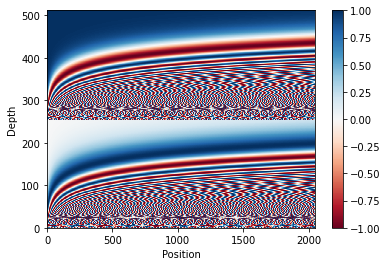

In [ ]:
n, d = 2048, 512
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)
pos_encoding = pos_encoding[0]

# Juggle the dimensions for the plot
pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2))
pos_encoding = tf.transpose(pos_encoding, (2, 1, 0))
pos_encoding = tf.reshape(pos_encoding, (d, n))

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

In [ ]:
#Masking
# Mask all the pad tokens in the batch of sequence. 
# It ensures that the model does not treat padding as the input. 
# The mask indicates where pad value 0 is present:
#  it outputs a 1 at those locations, and a 0 otherwise.
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1

In [ ]:
# !pip install tensorflow-probability

In [ ]:
# import tensorflow_probability as tfp

In [ ]:
# The look-ahead mask is used to mask the future tokens in a sequence.
#  In other words, the mask indicates which entries should not be used.

# This means that to predict the third token, only the first and second token
#  will be used. Similarly to predict the fourth token, only the first,
#   second and the third tokens will be used and so on.

def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)


# def create_look_ahead_mask(size):
#     n = int(size * (size+1) / 2)
#     mask = tfp.math.fill_triangular(tf.ones((n,), dtype=tf.int32), upper=False)

In [ ]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead)
  but it must be broadcastable for addition.

  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

In [ ]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print('Attention weights are:')
  print(temp_attn)
  print('Output is:')
  print(temp_out)

In [ ]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10, 0, 0],
                      [0, 10, 0],
                      [0, 0, 10],
                      [0, 0, 10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[1, 0],
                      [10, 0],
                      [100, 5],
                      [1000, 6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:

tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)

Output is:

tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [ ]:
class MultiHeadAttention(keras.layers.Layer):
  def __init__(self,*, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = keras.layers.Dense(d_model)
    self.wk = keras.layers.Dense(d_model)
    self.wv = keras.layers.Dense(d_model)

    self.dense = keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

    return output, attention_weights

In [ ]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

In [ ]:
def point_wise_feed_forward_network(d_model, dff):
  return keras.Sequential([
      keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [ ]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

In [ ]:
class EncoderLayer(keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = keras.layers.Dropout(rate)
    self.dropout2 = keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

    return out2

In [ ]:
sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

In [ ]:
class DecoderLayer(keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
    self.mha2 = MultiHeadAttention(d_model=d_model, num_heads=num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = keras.layers.Dropout(rate)
    self.dropout2 = keras.layers.Dropout(rate)
    self.dropout3 = keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)

    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

    return out3, attn_weights_block1, attn_weights_block2

In [ ]:
sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output,
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

In [ ]:

#encoder consists of input embedding , positional encoding and n encoder layers

class Encoder(keras.layers.Layer):
  def __init__(self,*, num_layers, d_model, num_heads, dff, input_vocab_size,
               rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(MAX_TOKENS, self.d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, rate=rate)
        for _ in range(num_layers)]

    self.dropout = keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]

    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)

    return x  # (batch_size, input_seq_len, d_model)

In [ ]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, input_vocab_size=8500)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print(sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


In [ ]:
class Decoder(keras.layers.Layer):
  def __init__(self,*, num_layers, d_model, num_heads, dff, target_vocab_size,
               rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(MAX_TOKENS, d_model)

    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, rate=rate)
        for _ in range(num_layers)]
    self.dropout = keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}

    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)

      attention_weights[f'decoder_layer{i+1}_block1'] = block1
      attention_weights[f'decoder_layer{i+1}_block2'] = block2

    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [ ]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, target_vocab_size=8000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input,
                              enc_output=sample_encoder_output,
                              training=False,
                              look_ahead_mask=None,
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

In [ ]:
class Transformer(keras.Model):
  def __init__(self,*, num_layers, d_model, num_heads, dff, input_vocab_size,
               target_vocab_size, rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           input_vocab_size=input_vocab_size, rate=rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           target_vocab_size=target_vocab_size, rate=rate)

    self.final_layer = keras.layers.Dense(target_vocab_size)

  def call(self, inputs, training):
    # Keras models prefer if you pass all your inputs in the first argument
    inp, tar = inputs

    padding_mask, look_ahead_mask = self.create_masks(inp, tar)

    enc_output = self.encoder(inp, training, padding_mask)  # (batch_size, inp_seq_len, d_model)

    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, padding_mask)

    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

    return final_output, attention_weights

  def create_masks(self, inp, tar):
    # Encoder padding mask (Used in the 2nd attention block in the decoder too.)
    padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    look_ahead_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return padding_mask, look_ahead_mask

In [ ]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048,
    input_vocab_size=8500, target_vocab_size=8000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer([temp_input, temp_target], training=False)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

In [ ]:
# hyperparameters
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-3)

Text(0.5, 0, 'Train Step')

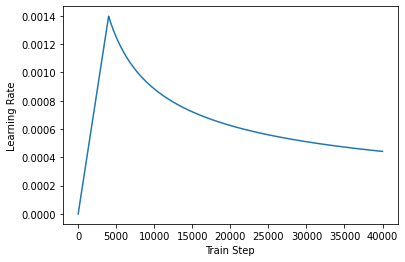

In [ ]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

In [ ]:
loss_object = keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [ ]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.argmax(pred, axis=2))

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [ ]:
train_loss = keras.metrics.Mean(name='train_loss')
train_accuracy = keras.metrics.Mean(name='train_accuracy')

In [ ]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.prob.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.sol.get_vocab_size().numpy(),
    rate=dropout_rate)

In [ ]:
checkpoint_path = './checkpoints/train'

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored!!')

In [ ]:
EPOCHS = 20

In [ ]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]


@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]

  with tf.GradientTape() as tape:
    predictions, _ = transformer([inp, tar_inp],
                                 training = True)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  train_loss(loss)
  train_accuracy(accuracy_function(tar_real, predictions))



In [ ]:
for epoch in range(EPOCHS):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()

  # inp -> problem pseudocode, tar -> solution in c++
  for (batch, (inp, tar)) in enumerate(train_batches):
    train_step(inp, tar)

    if batch % 50 == 0:
      print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

  print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')
  


Epoch 1 Batch 0 Loss 7.4912 Accuracy 0.0002

Epoch 1 Batch 50 Loss 7.3849 Accuracy 0.0003

Epoch 1 Loss 7.3849 Accuracy 0.0003

Time taken for 1 epoch: 1321.08 secs



Epoch 2 Batch 0 Loss 7.1790 Accuracy 0.0013

Epoch 2 Loss 6.9869 Accuracy 0.0713

Time taken for 1 epoch: 1136.27 secs



Epoch 3 Batch 0 Loss 6.7787 Accuracy 0.0984

Epoch 3 Batch 50 Loss 6.6311 Accuracy 0.0942

Epoch 3 Loss 6.6111 Accuracy 0.0941

Time taken for 1 epoch: 1538.02 secs



Epoch 4 Batch 0 Loss 6.4191 Accuracy 0.0956

Epoch 4 Batch 50 Loss 6.2278 Accuracy 0.0936

Epoch 4 Loss 6.1910 Accuracy 0.0937

Time taken for 1 epoch: 1643.00 secs



Epoch 5 Batch 0 Loss 5.9312 Accuracy 0.0944

Epoch 5 Batch 50 Loss 5.6975 Accuracy 0.0938

Saving checkpoint for epoch 5 at ./checkpoints/train/ckpt-1

Epoch 5 Loss 5.6922 Accuracy 0.0939

Time taken for 1 epoch: 1360.38 secs



Epoch 6 Batch 0 Loss 5.4369 Accuracy 0.0904

Epoch 6 Batch 50 Loss 5.1798 Accuracy 0.0946

Epoch 6 Loss 5.1388 Accuracy 0.0944

Time taken for 1 

In [ ]:
class Translator(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS):
    # input sentence is problem statement, hence adding the start and end token
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.prob.tokenize(sentence).to_tensor()

    encoder_input = sentence

    # As the output language is cpp program, initialize the output with the
    # english start token.
    start_end = self.tokenizers.sol.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # `tf.TensorArray` is required here (instead of a python list) so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions, _ = self.transformer([encoder_input, output], training=False)

      # select the last token from the seq_len dimension
      predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)

      predicted_id = tf.argmax(predictions, axis=-1)

      # concatentate the predicted_id to the output which is given to the decoder
      # as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # output.shape (1, tokens)
    text = tokenizers.sol.detokenize(output)[0]  # shape: ()

    tokens = tokenizers.sol.lookup(output)[0]

    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop. So recalculate them outside
    # the loop.
    _, attention_weights = self.transformer([encoder_input, output[:,:-1]], training=False)

    return text, tokens, attention_weights

In [ ]:
translator = Translator(tokenizers, transformer)

In [ ]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground truth":15s}: {ground_truth}')

In [ ]:
sentence = 'declare integers num1 num2'
ground_truth = 'int num1,num2;'

translated_text, translated_tokens, attention_weights = translator( tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : declare integers num1 num2

Prediction     : int n _ b _ b _ b _ b _ b _ b _ b _ b _ b _ b _ b ; cin > > > > > > > > > > > > > > > > > > > > > > b ; cout < < < < < < < < < < < < < < < < < < < < < < < < < < < < < < < < < < < < < < < < < < < < < < < < < < < < < < < < < < < < < < < < < < < < < < < " ; }

Ground truth   : int num1,num2;


In [ ]:
sentence = 'create map iterator it from string to integer    create integer n    read n    read character    for i = 0 to n exclusive    create sting str    read line from cin to str    set m[str] to 1    create integer ans with ans = 0    for it = beginning of m to it is not end of m_ incrementing it_ increment ans    print ans print newline    '
ground_truth = 'map<string_ int>::iterator it;    int main() {    int n;    cin >> n;    getchar();    for (int i = 0; i < n; i++) {    string str;    getline(cin_ str);    m[str] = 1;    }    int ans = 0;    for (it = m.begin(); it != m.end(); it++) { ans++; }    cout << ans << endl;    }    '

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : create map iterator it from string to integer nxtlin create integer n nxtlin read n nxtlin read character nxtlin for i = 0 to n exclusive nxtlin create sting str nxtlin read line from cin to str nxtlin set m[str] to 1 nxtlin create integer ans with ans = 0 nxtlin for it = beginning of m to it is not end of m_ incrementing it_ increment ans nxtlin print ans print newline nxtlin 

Prediction     : int n _ m _ m _ m _ m _ m _ m _ m _ m _ m _ m _ m _ m _ m _ m _ m _ m _ m _ m _ m _ m _ m _ m _ m _ m _ i = 0 ; cin > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > k ; for ( i = 0 ; i + + + + + + + + + + ) { if ( i + + + + + + ) { if ( i + + + + + + + + ) cout < < < < < < < < < < < < < < < < < < < < < < < < endl ; }

Ground truth   : map<string_ int>::iterator it; nxtlin int main() { nxtlin int n; nxtlin cin >> n; nxtlin getchar(); nxtlin for (int i = 0; i < n; i++) { nxtlin string str; nxtlin getline(cin_ str); nxtlin m[str] = 1; nxtlin } nxtlin int ans

In [ ]:
sentence = 'let t an int      read t      while postdecrement t      let s a string      read s      if size of s at most 10      print s      continue      otherwise      print s[0]_ followed by size of s less 2_ followed by s[size of s less 1]      '
ground_truth = 'int n_ m_ i_ j_ pos = 0;      cin >> n >> m;      int c[n]_ a[m];      for (i = 0; i < n; i++) { cin >> c[i]; }      for (j = 0; j < m; j++) { cin >> a[j]; }      for (i = 0; i < n; i++) {      if (pos < m) {      if (a[pos] >= c[i]) {      pos = pos + 1;      } else {      continue;      }      }      }      cout << pos << endl;      return 0;      }      '

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

In [ ]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  # The plot is of the attention when a token was generated.
  # The model didn't generate `<START>` in the output. Skip it.
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(
      labels, rotation=90)

  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)

In [ ]:
head = 0
# shape: (batch=1, num_heads, seq_len_q, seq_len_k)
attention_heads = tf.squeeze(
  attention_weights['decoder_layer4_block2'], 0)
attention = attention_heads[head]
attention.shape

In [ ]:
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.prob.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.prob.lookup(in_tokens)[0]
in_tokens

In [ ]:
translated_tokens

In [ ]:
plot_attention_head(in_tokens, translated_tokens, attention)

In [ ]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
  in_tokens = tf.convert_to_tensor([sentence])
  in_tokens = tokenizers.prob.tokenize(in_tokens).to_tensor()
  in_tokens = tokenizers.prob.lookup(in_tokens)[0]
  in_tokens

  fig = plt.figure(figsize=(16, 8))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)

    plot_attention_head(in_tokens, translated_tokens, head)

    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.show()

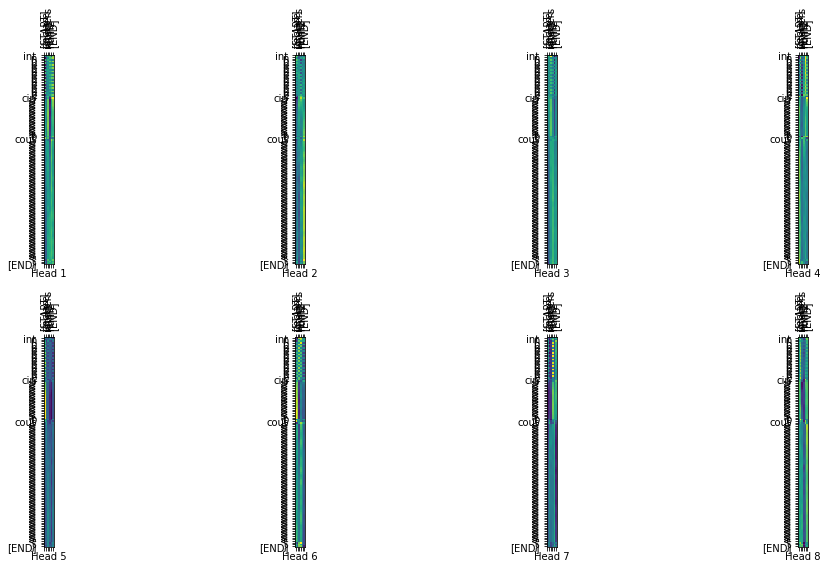

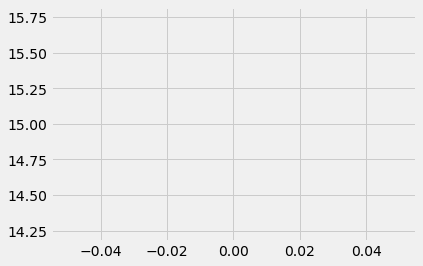

In [ ]:
import random
from itertools import count
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import style

plt.style.use('fivethirtyeight')

fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
x_values = []
y_values = []

index = count()

def animate(i):
   x_values.append(next(index))
   y_values.append(random.randint(0,15))
  #  print(x_values,y_values)
   ax1.clear()
   ax1.plot(x_values,y_values,color = 'r')
  # plt.scatter(x_values,y_values)

ani = FuncAnimation(plt.gcf(),animate,interval = 1000)

plt.tight_layout()
plt.show()

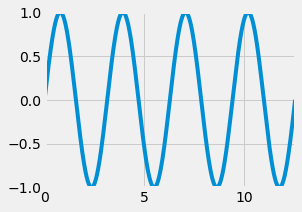

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

x = []
y = []

figure, ax = plt.subplots(figsize=(4,3))
line, = ax.plot(x, y)
plt.axis([0, 4*np.pi, -1, 1])

def func_animate(i):
    x = np.linspace(0, 4*np.pi, 1000)
    y = np.sin(2 * (x - 0.1 * i))
    
    line.set_data(x, y)
    
    return line,

ani = FuncAnimation(figure,
                    func_animate,
                    frames=10,
                    interval=5)

# ani.save(r'animation.gif', fps=10)

plt.show()
# 